In [1]:
# import libraries

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

2023-04-21 14:34:24.274041: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-21 14:34:24.374756: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-21 14:34:24.376041: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 14:34:25.778193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# run the data_processing file to get the training and validation sets

%run ../data_processing.ipynb

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16626 entries, 0 to 16625
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Administrative  16626 non-null  int64  
 1   Informational   16626 non-null  int64  
 2   ProductRelated  16626 non-null  int64  
 3   ExitRates       16626 non-null  float64
 4   PageValues      16626 non-null  float64
 5   SpecialDay      16626 non-null  float64
 6   Month           16626 non-null  int64  
 7   Region          16626 non-null  int64  
 8   TrafficType     16626 non-null  int64  
 9   VisitorType0    16626 non-null  float64
 10  VisitorType1    16626 non-null  float64
 11  Weekend         16626 non-null  int64  
 12  Revenue         16626 non-null  int64  
dtypes: float64(5), int64(8)
memory usage: 1.6 MB


In [3]:
# compile parameters (can be updated for different variations and test)
X_TRAIN = x_train
Y_TRAIN = y_train

X_VALID = x_valid
Y_VALID = y_valid

X_TEST = x_test
Y_TEST = y_test

VALIDATION = (x_valid, y_valid)

ACTIVATION_FUNCTION = 'relu'
ACTIVATION_FUNCTION_OUTPUT = 'softmax'
BATCH_SIZE = 32
INPUT_DIM = 12
KERNEL_INITIALIZER = 'he_uniform'
LEARNING_RATE = 0.03
LOSS_FUNCTION = 'categorical_crossentropy'
METRICS = ['accuracy']
OPTIMIZER = tf.optimizers.legacy.Adam(learning_rate=LEARNING_RATE)
VERBOSE = 0

# list of epoch sizes to test (can be updated to test different number of epochs)
epoch_size = [10, 25, 50, 100, 200, 500]

# dataframe to hold the loss and accuracy for each epoch size
df_result = pd.DataFrame(columns=['epochs', 'training_loss',
                                  'training_accuracy', 'validation_loss',
                                  'validation_accuracy', 'test_loss',
                                  'test_accuracy'])

# clears the dataset to avoid redundancy
df_result = df_result.iloc[0:0]

In [4]:
# create a baseline classifier
def create_baseline():

    # init a sequential NN
    classifier = Sequential()

    # Define the model architecture
    
    # 1st layer - takes in input
    classifier.add(Dense(units=512, kernel_initializer=KERNEL_INITIALIZER,
                         activation=ACTIVATION_FUNCTION, input_dim=INPUT_DIM))
    # 2nd layer
    classifier.add(Dense(units=128, kernel_initializer=KERNEL_INITIALIZER,
                         activation=ACTIVATION_FUNCTION))
    # 3rd layer
    classifier.add(Dense(units=96, kernel_initializer=KERNEL_INITIALIZER,
                         activation=ACTIVATION_FUNCTION))
    # output layer
    classifier.add(Dense(units=2, kernel_initializer=KERNEL_INITIALIZER,
                         activation=ACTIVATION_FUNCTION_OUTPUT))

    return classifier

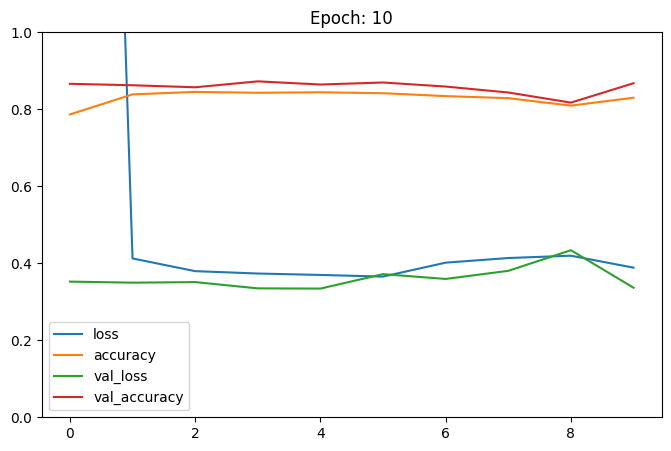

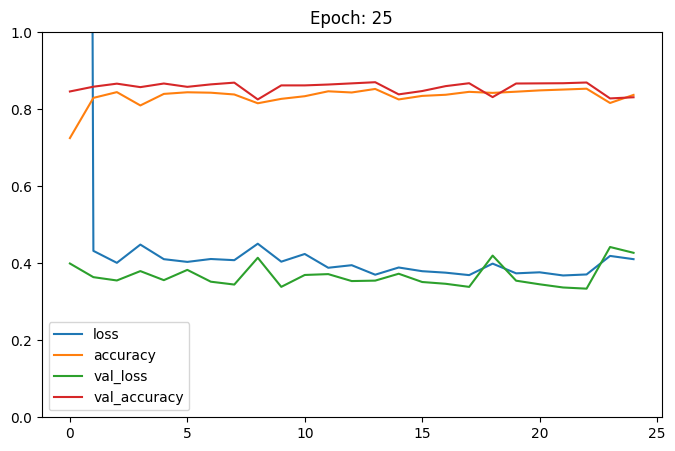

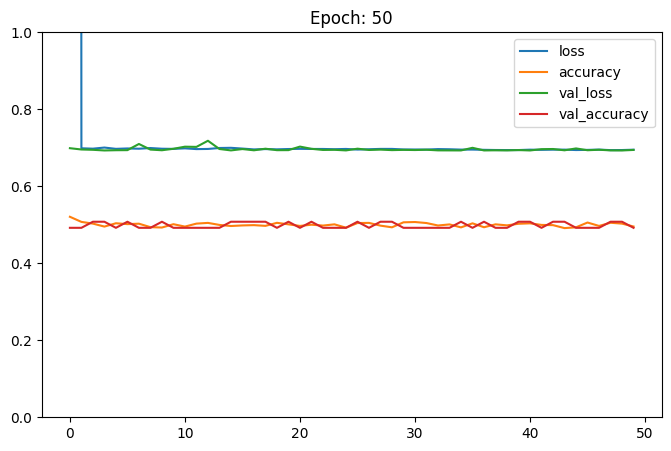

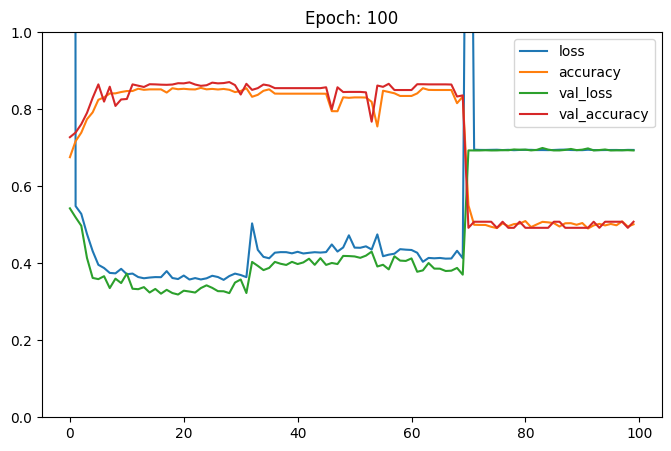

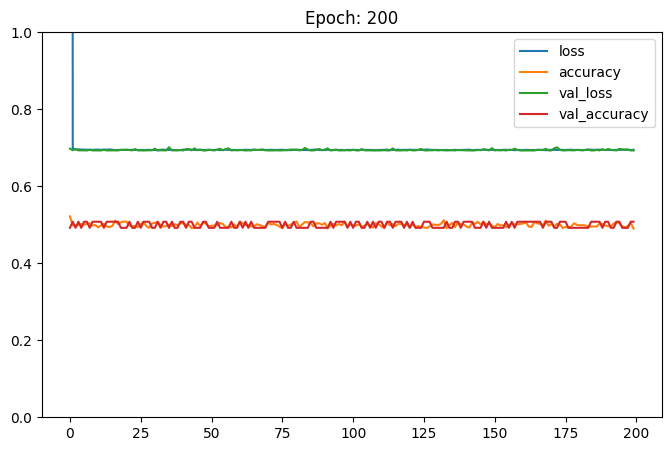

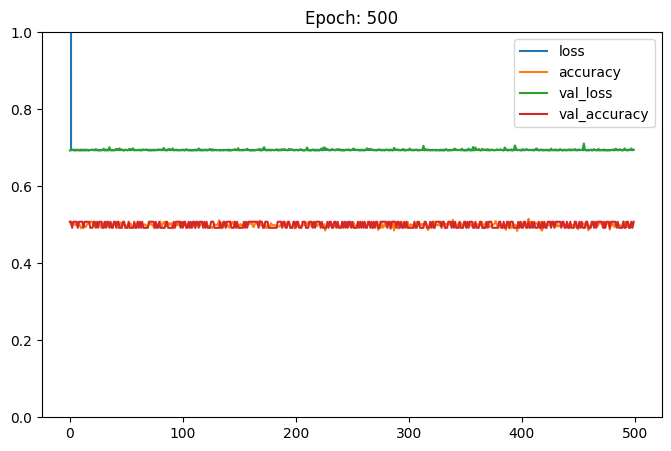

In [5]:
# loop through the epoch_size list to test all the epoch sizes
for EPOCHS in epoch_size:
    
    # create a baseline model
    model = create_baseline()

    # compile the model with values defined above
    model.compile(optimizer=OPTIMIZER,
                  loss=LOSS_FUNCTION, metrics=METRICS)
    
    # train the model
    history = model.fit(X_TRAIN, Y_TRAIN, validation_data=VALIDATION,
                            epochs=EPOCHS, batch_size=BATCH_SIZE,
                            verbose=VERBOSE)

    # plot
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid = True
    plt.ylim(0, 1)
    plt.title('Epoch: ' + str(EPOCHS))
    plt.savefig('figures/epochs_'+str(EPOCHS)+'.png')
    plt.show()

    # evaluation - loss and accuracy
    model_train_loss, model_train_accuracy = model.evaluate(X_TRAIN, Y_TRAIN,
                                                            verbose=VERBOSE)
    model_valid_loss, model_valid_accuracy = model.evaluate(X_VALID, Y_VALID,
                                                            verbose=VERBOSE)
    model_test_loss, model_test_accuracy = model.evaluate(X_TEST, Y_TEST,
                                                          verbose=VERBOSE)

    # add the evaluation results to the dataset
    df_result = pd.concat([pd.DataFrame([[EPOCHS,
                                          model_train_loss,
                                          model_train_accuracy,
                                          model_valid_loss,
                                          model_valid_accuracy,
                                          model_test_loss,
                                          model_test_accuracy]],
                                          columns=df_result.columns),
                                          df_result],
                                          ignore_index=True)

In [6]:
# display the evaluation results dataframe

df_result

,epochs,training_loss,training_accuracy,validation_loss,validation_accuracy,test_loss,test_accuracy
0,500,0.696148,0.498120,0.694704,0.507895,0.701840,0.499399
1,200,0.693254,0.498120,0.693033,0.507895,0.693218,0.499699
2,100,0.693184,0.498120,0.693034,0.507895,0.693214,0.499699
3,50,0.693676,0.501880,0.694390,0.492105,0.693792,0.500301
4,25,0.436562,0.825282,0.427184,0.831203,0.444878,0.820806
5,10,0.366883,0.857895,0.336531,0.867669,0.373615,0.852375


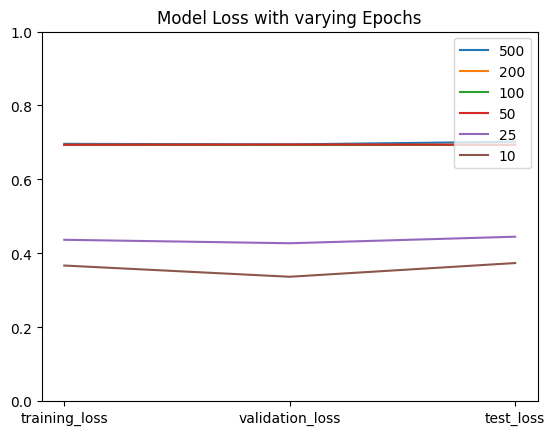

In [7]:
# visualize loss for training, validation and test sets

# x values
x = ['training_loss', 'validation_loss', 'test_loss']

# training and validation loss for each epoch size
for _idx in range(df_result.shape[0]):
    plt.plot(x, [df_result.iloc[_idx]['training_loss'],
                 df_result.iloc[_idx]['validation_loss'],
                 df_result.iloc[_idx]['test_loss']],
                 label=str(df_result.iloc[_idx]['epochs']))

# plot
plt.grid = True
plt.ylim(0, 1)
plt.title('Model Loss with varying Epochs')
plt.legend(loc='upper right')
plt.savefig('figures/loss.png')
plt.show()

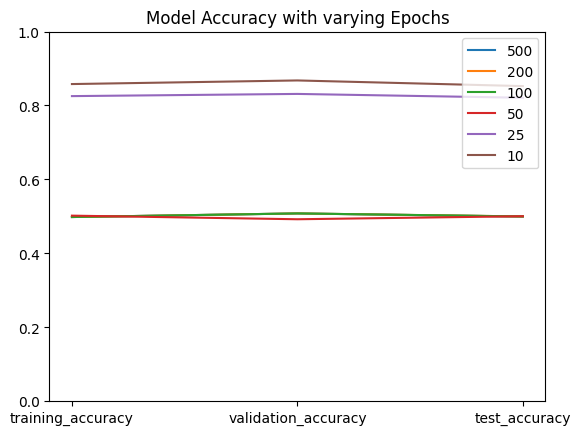

In [8]:
# visualize accuracy for training, validation and test sets

# x values
x = ['training_accuracy', 'validation_accuracy', 'test_accuracy']

# training and validation accuracy for each epoch size
for _idx in range(df_result.shape[0]):
    plt.plot(x, [df_result.iloc[_idx]['training_accuracy'],
                 df_result.iloc[_idx]['validation_accuracy'],
                 df_result.iloc[_idx]['test_accuracy']],
                 label=str(df_result.iloc[_idx]['epochs']))

# plot
plt.grid = True
plt.ylim(0, 1)
plt.title('Model Accuracy with varying Epochs')
plt.legend(loc='upper right')
plt.savefig('figures/accuracy.png')
plt.show()